<a href="https://colab.research.google.com/github/anshu1910/Delivery-Time-Estimating-Model/blob/main/My_Cassandra2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/dataset/train_data.csv")

In [ ]:
data.head()

,UID,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,cutoff_timestamp,actual_distance_to_destination,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,actual_time
0,lWYYrbNEdf,2018-09-15 02:23:18.656742,thanos::sroute:9d8ed3f7-a8af-4393-ad7a-c57a720...,FTL,trip-153697819865649878,IND832109AAB,Jamshedpur_Central_I_3 (Jharkhand),IND834002AAB,Ranchi_Hub (Jharkhand),2018-09-15 02:23:18.656742,...,2018-09-15 04:45:23,158.807515,778.672716,1228.735753,2.782826,77.988686,20.793472,28.475783,3.292773,100.0
1,iNJcHQlPCm,2018-09-30 15:07:48.971326,thanos::sroute:b9142a73-d68f-46ec-9afc-d145479...,FTL,trip-153832006897106333,IND422011AAD,Nashik_TgrniaRD_I (Maharashtra),IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),2018-09-30 22:38:13.903069,...,2018-10-01 05:38:30,81.388109,227.479029,NaN,3.625248,68.517914,18.787231,34.612259,4.277350,61.0
2,U6N0M43qwR,2018-09-23 22:15:46.635975,thanos::sroute:883e99fa-50a3-40e0-a2e2-9b12ed6...,FTL,trip-153774094663572416,IND845305AAA,Raxaul_KairiyaT_D (Bihar),NaN,Muzaffrpur_Bbganj_I (Bihar),2018-09-24 03:56:37.016232,...,2018-09-24 09:21:30,134.486898,400.072069,1188.943158,4.415969,70.475386,24.371978,29.867950,5.322072,69.0
3,RrJUneuYNj,2018-09-21 05:11:44.833176,thanos::sroute:96a80600-40e1-436b-9161-fa68f9e...,FTL,trip-153750670483274503,IND842001AAA,Muzaffrpur_Bbganj_I (Bihar),IND854326AAB,Purnia_Central_H_2 (Bihar),2018-09-22 10:08:32.593022,...,2018-09-22 14:09:17,262.866674,510.123878,999.421258,2.946647,101.876844,19.588977,27.794019,4.265799,300.0
4,7QLdD7iRC9,2018-09-18 01:10:49.936747,thanos::sroute:b43ec86d-59c1-452c-b4a9-807d357...,FTL,trip-153723305402762987,IND411033AAA,Pune_Tathawde_H (Maharashtra),IND501359AAE,Hyderabad_Shamshbd_H (Telangana),2018-09-18 01:10:49.936747,...,2018-09-18 12:14:05,379.389280,NaN,NaN,1.998790,46.571301,22.671495,26.971844,3.553652,286.0


In [ ]:
data.shape

(72158, 24)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72158 entries, 0 to 72157
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   UID                             72158 non-null  object 
 1   trip_creation_time              68643 non-null  object 
 2   route_schedule_uuid             69263 non-null  object 
 3   route_type                      72158 non-null  object 
 4   trip_uuid                       72158 non-null  object 
 5   source_center                   72158 non-null  object 
 6   source_name                     72158 non-null  object 
 7   destination_center              71355 non-null  object 
 8   destination_name                72158 non-null  object 
 9   od_start_time                   72158 non-null  object 
 10  od_end_time                     71438 non-null  object 
 11  start_scan_to_end_scan          72158 non-null  float64
 12  is_cutoff                       

In [ ]:
data['od_start_time'] = pd.to_datetime(data['od_start_time'])
data['od_end_time'] = pd.to_datetime(data['od_end_time'])
data['trip_creation_time'] = pd.to_datetime(data['trip_creation_time'])
data['cutoff_timestamp'] = pd.to_datetime(data['cutoff_timestamp'])

data['date_diffs_lambda'] = data.apply(lambda row:
                                   (row['od_end_time'] - row['od_start_time']).total_seconds()
                                   ,axis=1)

data['date_diffs_lambda2'] = data.apply(lambda row:
                                   (row['od_start_time'] - row['trip_creation_time']).total_seconds()
                                   ,axis=1)



data['date_diffs_lambda3'] = data.apply(lambda row:
                                   (row['cutoff_timestamp'] - row['trip_creation_time']).total_seconds()
                                   ,axis=1)

data['date_diffs_lambda4'] = data.apply(lambda row:
                                   (row['od_end_time'] - row['cutoff_timestamp']).total_seconds()
                                   ,axis=1)

data['date_diffs_lambda5'] = data.apply(lambda row:
                                   (row['od_end_time'] - row['trip_creation_time']).total_seconds()
                                   ,axis=1)

data['date_diffs_lambda6'] = data.apply(lambda row:
                                   (row['cutoff_timestamp'] - row['od_start_time']).total_seconds()
                                   ,axis=1)




In [ ]:
# data.drop(['trip_creation_time'], axis=1, inplace=True)
# data.drop(['od_start_time'], axis=1, inplace=True)
# data.drop(['od_end_time'], axis=1, inplace=True)
# data.drop(['cutoff_timestamp'], axis=1, inplace=True)

In [ ]:
# data.interpolate(method ='linear', limit_direction ='forward', inplace=True)
# data.isnull().sum()

In [ ]:
#data['segment_factor'].mean()

In [ ]:
#data['segment_factor'].fillna(data['segment_factor'].mean(), inplace = True)

In [ ]:
#data['factor'].fillna(data['factor'].mean(), inplace = True)

In [ ]:
#data['osrm_distance'].fillna(data['osrm_distance'].mean(), inplace = True)

In [ ]:
#data['osrm_time'].fillna(data['osrm_time'].mean(), inplace = True)

In [ ]:
#mode_of_trip_creation_time = data.pivot_table(values="trip_creation_time", columns="route_type", aggfunc=(lambda x: x.mode()))

In [ ]:
#print(mode_of_trip_creation_time)

<Axes: xlabel='route_type'>

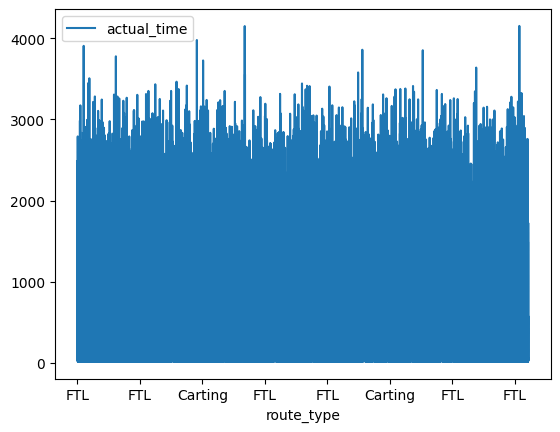

In [ ]:
data.plot(x='route_type', y='actual_time')

In [ ]:
data.trip_creation_time.fillna(data.od_start_time, inplace=True)
data.isnull().sum()


UID                                   0
trip_creation_time                    0
route_schedule_uuid                2895
route_type                            0
trip_uuid                             0
source_center                         0
source_name                           0
destination_center                  803
destination_name                      0
od_start_time                         0
od_end_time                         720
start_scan_to_end_scan                0
is_cutoff                             0
cutoff_factor                         0
cutoff_timestamp                    930
actual_distance_to_destination        0
osrm_time                         14432
osrm_distance                     14432
factor                             1644
segment_actual_time                   0
segment_osrm_time                     0
segment_osrm_distance                 0
segment_factor                     1159
actual_time                           0
date_diffs_lambda                   720


In [ ]:
data.columns

Index(['UID', 'trip_creation_time', 'route_schedule_uuid', 'route_type',
       'trip_uuid', 'source_center', 'source_name', 'destination_center',
       'destination_name', 'od_start_time', 'od_end_time',
       'start_scan_to_end_scan', 'is_cutoff', 'cutoff_factor',
       'cutoff_timestamp', 'actual_distance_to_destination', 'osrm_time',
       'osrm_distance', 'factor', 'segment_actual_time', 'segment_osrm_time',
       'segment_osrm_distance', 'segment_factor', 'actual_time',
       'date_diffs_lambda', 'date_diffs_lambda2', 'date_diffs_lambda3',
       'date_diffs_lambda4', 'date_diffs_lambda5', 'date_diffs_lambda6'],
      dtype='object')

In [ ]:
data.shape


(72158, 30)

In [ ]:
data["destination_name"].nunique()

1433

In [ ]:
#data.dropna(subset=['cutoff_timestamp'], inplace=True)

In [ ]:
data.isnull().sum()


UID                                   0
trip_creation_time                    0
route_schedule_uuid                2895
route_type                            0
trip_uuid                             0
source_center                         0
source_name                           0
destination_center                  803
destination_name                      0
od_start_time                         0
od_end_time                         720
start_scan_to_end_scan                0
is_cutoff                             0
cutoff_factor                         0
cutoff_timestamp                    930
actual_distance_to_destination        0
osrm_time                         14432
osrm_distance                     14432
factor                             1644
segment_actual_time                   0
segment_osrm_time                     0
segment_osrm_distance                 0
segment_factor                     1159
actual_time                           0
date_diffs_lambda                   720


In [ ]:
#data.drop(['route_schedule_uuid'], axis=1, inplace=True)

In [ ]:
data.isnull().sum()

UID                                   0
trip_creation_time                    0
route_schedule_uuid                2895
route_type                            0
trip_uuid                             0
source_center                         0
source_name                           0
destination_center                  803
destination_name                      0
od_start_time                         0
od_end_time                         720
start_scan_to_end_scan                0
is_cutoff                             0
cutoff_factor                         0
cutoff_timestamp                    930
actual_distance_to_destination        0
osrm_time                         14432
osrm_distance                     14432
factor                             1644
segment_actual_time                   0
segment_osrm_time                     0
segment_osrm_distance                 0
segment_factor                     1159
actual_time                           0
date_diffs_lambda                   720


In [ ]:
data.dropna(subset=['destination_center'], inplace=True)

In [ ]:
data.isnull().sum()

UID                                   0
trip_creation_time                    0
route_schedule_uuid                2864
route_type                            0
trip_uuid                             0
source_center                         0
source_name                           0
destination_center                    0
destination_name                      0
od_start_time                         0
od_end_time                         714
start_scan_to_end_scan                0
is_cutoff                             0
cutoff_factor                         0
cutoff_timestamp                    922
actual_distance_to_destination        0
osrm_time                         14285
osrm_distance                     14252
factor                             1630
segment_actual_time                   0
segment_osrm_time                     0
segment_osrm_distance                 0
segment_factor                     1144
actual_time                           0
date_diffs_lambda                   714


In [ ]:
#data.dropna(subset=['od_end_time'], inplace=True)

In [ ]:
data.isnull().sum()

UID                                   0
trip_creation_time                    0
route_schedule_uuid                2864
route_type                            0
trip_uuid                             0
source_center                         0
source_name                           0
destination_center                    0
destination_name                      0
od_start_time                         0
od_end_time                         714
start_scan_to_end_scan                0
is_cutoff                             0
cutoff_factor                         0
cutoff_timestamp                    922
actual_distance_to_destination        0
osrm_time                         14285
osrm_distance                     14252
factor                             1630
segment_actual_time                   0
segment_osrm_time                     0
segment_osrm_distance                 0
segment_factor                     1144
actual_time                           0
date_diffs_lambda                   714


In [ ]:
data.describe()

,start_scan_to_end_scan,cutoff_factor,actual_distance_to_destination,osrm_time,osrm_distance,factor,segment_actual_time,segment_osrm_time,segment_osrm_distance,segment_factor,actual_time,date_diffs_lambda,date_diffs_lambda2,date_diffs_lambda3,date_diffs_lambda4,date_diffs_lambda5,date_diffs_lambda6
count,71355.000000,71355.000000,71355.000000,57070.000000,57103.000000,69725.000000,71355.000000,71355.000000,71355.000000,70211.000000,71355.000000,70641.000000,67876.000000,66998.000000,69731.000000,67193.000000,70433.000000
mean,1191.715877,233.337271,301.764862,645.111505,868.811800,2.559494,46.562696,22.447398,27.692184,3.002761,418.047775,57887.829010,15936.610700,46562.348578,27192.832175,73621.743910,30731.255173
std,1053.193283,345.853483,349.592906,420.222745,572.549049,1.730999,54.465128,16.223304,19.955589,4.431865,600.187513,62281.476348,28800.402621,48832.412592,36471.799079,68160.209119,40330.430748
min,32.280981,9.000000,9.135918,20.768357,14.965570,0.299470,-236.341748,0.003620,0.003119,-6.048567,9.000000,1242.168787,0.000000,0.000000,543.320653,1690.746919,0.000000
25%,390.698684,22.000000,84.072038,326.264430,431.489237,1.945595,28.398859,15.127577,17.450655,1.915536,51.000000,9703.044905,0.000000,11148.715702,4178.244924,17894.108201,3634.640671
50%,727.546856,66.000000,152.485588,552.985431,742.204030,2.304032,39.133965,20.765992,27.238293,2.504142,131.000000,27133.449545,0.000000,28142.203713,10208.065107,45926.368090,12389.413055
75%,1876.405590,286.000000,359.733092,868.360508,1176.389678,2.769558,52.714883,26.851677,33.691260,3.284162,513.000000,98097.008596,22238.206183,66925.402994,34505.464313,124542.301110,42179.340862
max,5271.669855,1914.000000,1949.210403,3186.653166,4156.700085,77.381429,3060.652522,1617.726759,2195.845793,362.559369,4154.000000,272142.913524,214500.880161,437879.870432,254106.936153,447536.371137,260126.590308


In [ ]:
sns.set()

<ipython-input-21-6cebdff1593e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["start_scan_to_end_scan"])


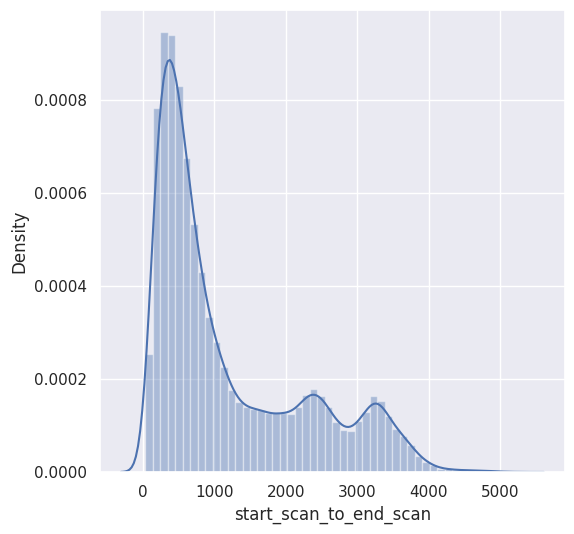

In [ ]:
plt.figure(figsize=(6,6))
sns.distplot(data["start_scan_to_end_scan"])
plt.show()

In [ ]:
data.head()

,UID,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,segment_osrm_time,segment_osrm_distance,segment_factor,actual_time,date_diffs_lambda,date_diffs_lambda2,date_diffs_lambda3,date_diffs_lambda4,date_diffs_lambda5,date_diffs_lambda6
0,lWYYrbNEdf,2018-09-15 02:23:18.656742,thanos::sroute:9d8ed3f7-a8af-4393-ad7a-c57a720...,FTL,trip-153697819865649878,IND832109AAB,Jamshedpur_Central_I_3 (Jharkhand),IND834002AAB,Ranchi_Hub (Jharkhand),2018-09-15 02:23:18.656742,...,20.793472,28.475783,3.292773,100.0,15017.167444,0.000000,8524.343258,6492.824186,15017.167444,8524.343258
1,iNJcHQlPCm,2018-09-30 15:07:48.971326,thanos::sroute:b9142a73-d68f-46ec-9afc-d145479...,FTL,trip-153832006897106333,IND422011AAD,Nashik_TgrniaRD_I (Maharashtra),IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),2018-09-30 22:38:13.903069,...,18.787231,34.612259,4.277350,61.0,29423.734408,27024.931743,52241.028674,4207.637477,56448.666151,25216.096931
3,RrJUneuYNj,2018-09-21 05:11:44.833176,thanos::sroute:96a80600-40e1-436b-9161-fa68f9e...,FTL,trip-153750670483274503,IND842001AAA,Muzaffrpur_Bbganj_I (Bihar),IND854326AAB,Purnia_Central_H_2 (Bihar),2018-09-22 10:08:32.593022,...,19.588977,27.794019,4.265799,300.0,32929.649866,104207.759846,118652.166824,18485.242888,137137.409712,14444.406978
4,7QLdD7iRC9,2018-09-18 01:10:49.936747,thanos::sroute:b43ec86d-59c1-452c-b4a9-807d357...,FTL,trip-153723305402762987,IND411033AAA,Pune_Tathawde_H (Maharashtra),IND501359AAE,Hyderabad_Shamshbd_H (Telangana),2018-09-18 01:10:49.936747,...,22.671495,26.971844,3.553652,286.0,60478.512504,0.000000,39795.063253,20683.449251,60478.512504,39795.063253
5,aCQiP8akOa,2018-10-01 18:06:41.031369,thanos::sroute:0456b740-1dad-4929-bbe0-87d8843...,FTL,trip-153841720103113533,IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-10-01 18:06:41.031369,...,35.429543,44.287435,2.661004,2489.0,182578.258957,0.000000,32687.968631,149890.290326,182578.258957,32687.968631


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71355 entries, 0 to 72157
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   UID                             71355 non-null  object        
 1   trip_creation_time              71355 non-null  datetime64[ns]
 2   route_schedule_uuid             68491 non-null  object        
 3   route_type                      71355 non-null  object        
 4   trip_uuid                       71355 non-null  object        
 5   source_center                   71355 non-null  object        
 6   source_name                     71355 non-null  object        
 7   destination_center              71355 non-null  object        
 8   destination_name                71355 non-null  object        
 9   od_start_time                   71355 non-null  datetime64[ns]
 10  od_end_time                     70641 non-null  datetime64[ns]
 11  st

In [ ]:
data["route_type"] = LabelEncoder().fit_transform(data["route_type"])

In [ ]:
data.head()

,UID,trip_creation_time,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,od_start_time,...,segment_osrm_time,segment_osrm_distance,segment_factor,actual_time,date_diffs_lambda,date_diffs_lambda2,date_diffs_lambda3,date_diffs_lambda4,date_diffs_lambda5,date_diffs_lambda6
0,lWYYrbNEdf,2018-09-15 02:23:18.656742,thanos::sroute:9d8ed3f7-a8af-4393-ad7a-c57a720...,1,trip-153697819865649878,IND832109AAB,Jamshedpur_Central_I_3 (Jharkhand),IND834002AAB,Ranchi_Hub (Jharkhand),2018-09-15 02:23:18.656742,...,20.793472,28.475783,3.292773,100.0,15017.167444,0.000000,8524.343258,6492.824186,15017.167444,8524.343258
1,iNJcHQlPCm,2018-09-30 15:07:48.971326,thanos::sroute:b9142a73-d68f-46ec-9afc-d145479...,1,trip-153832006897106333,IND422011AAD,Nashik_TgrniaRD_I (Maharashtra),IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),2018-09-30 22:38:13.903069,...,18.787231,34.612259,4.277350,61.0,29423.734408,27024.931743,52241.028674,4207.637477,56448.666151,25216.096931
3,RrJUneuYNj,2018-09-21 05:11:44.833176,thanos::sroute:96a80600-40e1-436b-9161-fa68f9e...,1,trip-153750670483274503,IND842001AAA,Muzaffrpur_Bbganj_I (Bihar),IND854326AAB,Purnia_Central_H_2 (Bihar),2018-09-22 10:08:32.593022,...,19.588977,27.794019,4.265799,300.0,32929.649866,104207.759846,118652.166824,18485.242888,137137.409712,14444.406978
4,7QLdD7iRC9,2018-09-18 01:10:49.936747,thanos::sroute:b43ec86d-59c1-452c-b4a9-807d357...,1,trip-153723305402762987,IND411033AAA,Pune_Tathawde_H (Maharashtra),IND501359AAE,Hyderabad_Shamshbd_H (Telangana),2018-09-18 01:10:49.936747,...,22.671495,26.971844,3.553652,286.0,60478.512504,0.000000,39795.063253,20683.449251,60478.512504,39795.063253
5,aCQiP8akOa,2018-10-01 18:06:41.031369,thanos::sroute:0456b740-1dad-4929-bbe0-87d8843...,1,trip-153841720103113533,IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),2018-10-01 18:06:41.031369,...,35.429543,44.287435,2.661004,2489.0,182578.258957,0.000000,32687.968631,149890.290326,182578.258957,32687.968631


In [ ]:
data.drop(['UID'], axis=1, inplace=True)

In [ ]:
#data.drop(['trip_uuid'], axis=1, inplace=True)
data.drop(['trip_creation_time'], axis=1, inplace=True)
data.drop(['od_start_time'], axis=1, inplace=True)
data.drop(['od_end_time'], axis=1, inplace=True)
data.drop(['cutoff_timestamp'], axis=1, inplace=True)

In [ ]:
#data.drop(['source_name'], axis=1, inplace=True)

In [ ]:
#data.drop(['destination_name'], axis=1, inplace=True)

In [ ]:
data.head()

,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,start_scan_to_end_scan,is_cutoff,cutoff_factor,...,segment_osrm_time,segment_osrm_distance,segment_factor,actual_time,date_diffs_lambda,date_diffs_lambda2,date_diffs_lambda3,date_diffs_lambda4,date_diffs_lambda5,date_diffs_lambda6
0,thanos::sroute:9d8ed3f7-a8af-4393-ad7a-c57a720...,1,trip-153697819865649878,IND832109AAB,Jamshedpur_Central_I_3 (Jharkhand),IND834002AAB,Ranchi_Hub (Jharkhand),713.521495,True,44,...,20.793472,28.475783,3.292773,100.0,15017.167444,0.000000,8524.343258,6492.824186,15017.167444,8524.343258
1,thanos::sroute:b9142a73-d68f-46ec-9afc-d145479...,1,trip-153832006897106333,IND422011AAD,Nashik_TgrniaRD_I (Maharashtra),IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),902.759458,True,22,...,18.787231,34.612259,4.277350,61.0,29423.734408,27024.931743,52241.028674,4207.637477,56448.666151,25216.096931
3,thanos::sroute:96a80600-40e1-436b-9161-fa68f9e...,1,trip-153750670483274503,IND842001AAA,Muzaffrpur_Bbganj_I (Bihar),IND854326AAB,Purnia_Central_H_2 (Bihar),705.451567,True,176,...,19.588977,27.794019,4.265799,300.0,32929.649866,104207.759846,118652.166824,18485.242888,137137.409712,14444.406978
4,thanos::sroute:b43ec86d-59c1-452c-b4a9-807d357...,1,trip-153723305402762987,IND411033AAA,Pune_Tathawde_H (Maharashtra),IND501359AAE,Hyderabad_Shamshbd_H (Telangana),1109.682268,True,198,...,22.671495,26.971844,3.553652,286.0,60478.512504,0.000000,39795.063253,20683.449251,60478.512504,39795.063253
5,thanos::sroute:0456b740-1dad-4929-bbe0-87d8843...,1,trip-153841720103113533,IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),3145.532578,True,1474,...,35.429543,44.287435,2.661004,2489.0,182578.258957,0.000000,32687.968631,149890.290326,182578.258957,32687.968631


In [ ]:
data.head()

,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,start_scan_to_end_scan,is_cutoff,cutoff_factor,...,segment_osrm_time,segment_osrm_distance,segment_factor,actual_time,date_diffs_lambda,date_diffs_lambda2,date_diffs_lambda3,date_diffs_lambda4,date_diffs_lambda5,date_diffs_lambda6
0,thanos::sroute:9d8ed3f7-a8af-4393-ad7a-c57a720...,1,trip-153697819865649878,IND832109AAB,Jamshedpur_Central_I_3 (Jharkhand),IND834002AAB,Ranchi_Hub (Jharkhand),713.521495,True,44,...,20.793472,28.475783,3.292773,100.0,15017.167444,0.000000,8524.343258,6492.824186,15017.167444,8524.343258
1,thanos::sroute:b9142a73-d68f-46ec-9afc-d145479...,1,trip-153832006897106333,IND422011AAD,Nashik_TgrniaRD_I (Maharashtra),IND421302AAG,Bhiwandi_Mankoli_HB (Maharashtra),902.759458,True,22,...,18.787231,34.612259,4.277350,61.0,29423.734408,27024.931743,52241.028674,4207.637477,56448.666151,25216.096931
3,thanos::sroute:96a80600-40e1-436b-9161-fa68f9e...,1,trip-153750670483274503,IND842001AAA,Muzaffrpur_Bbganj_I (Bihar),IND854326AAB,Purnia_Central_H_2 (Bihar),705.451567,True,176,...,19.588977,27.794019,4.265799,300.0,32929.649866,104207.759846,118652.166824,18485.242888,137137.409712,14444.406978
4,thanos::sroute:b43ec86d-59c1-452c-b4a9-807d357...,1,trip-153723305402762987,IND411033AAA,Pune_Tathawde_H (Maharashtra),IND501359AAE,Hyderabad_Shamshbd_H (Telangana),1109.682268,True,198,...,22.671495,26.971844,3.553652,286.0,60478.512504,0.000000,39795.063253,20683.449251,60478.512504,39795.063253
5,thanos::sroute:0456b740-1dad-4929-bbe0-87d8843...,1,trip-153841720103113533,IND000000ACB,Gurgaon_Bilaspur_HB (Haryana),IND562132AAA,Bangalore_Nelmngla_H (Karnataka),3145.532578,True,1474,...,35.429543,44.287435,2.661004,2489.0,182578.258957,0.000000,32687.968631,149890.290326,182578.258957,32687.968631


In [ ]:

data["is_cutoff"] = LabelEncoder().fit_transform(data["is_cutoff"])

In [ ]:
data["source_center"] = LabelEncoder().fit_transform(data["source_center"])

In [ ]:
data["destination_center"] = LabelEncoder().fit_transform(data["destination_center"])

In [ ]:
data["route_schedule_uuid"] = LabelEncoder().fit_transform(data["route_schedule_uuid"])
data["source_name"] = LabelEncoder().fit_transform(data["source_name"])
data["destination_name"] = LabelEncoder().fit_transform(data["destination_name"])
data["destination_name"] = LabelEncoder().fit_transform(data["destination_name"])
data["trip_uuid"] = LabelEncoder().fit_transform(data["trip_uuid"])

In [ ]:
#data.dropna(subset=['date_diffs_lambda2'], inplace=True)
#data.dropna(subset=['date_diffs_lambda3'], inplace=True)


In [ ]:

data.head()

,route_schedule_uuid,route_type,trip_uuid,source_center,source_name,destination_center,destination_name,start_scan_to_end_scan,is_cutoff,cutoff_factor,...,segment_osrm_time,segment_osrm_distance,segment_factor,actual_time,date_diffs_lambda,date_diffs_lambda2,date_diffs_lambda3,date_diffs_lambda4,date_diffs_lambda5,date_diffs_lambda6
0,857,1,2123,1411,635,1389,1162,713.521495,1,44,...,20.793472,28.475783,3.292773,100.0,15017.167444,0.000000,8524.343258,6492.824186,15017.167444,8524.343258
1,1026,1,11654,584,1005,577,198,902.759458,1,22,...,18.787231,34.612259,4.277350,61.0,29423.734408,27024.931743,52241.028674,4207.637477,56448.666151,25216.096931
3,821,1,6093,1416,965,1430,1124,705.451567,1,176,...,19.588977,27.794019,4.265799,300.0,32929.649866,104207.759846,118652.166824,18485.242888,137137.409712,14444.406978
4,999,1,3992,542,1137,719,567,1109.682268,1,198,...,22.671495,26.971844,3.553652,286.0,60478.512504,0.000000,39795.063253,20683.449251,60478.512504,39795.063253
5,24,1,12226,8,522,878,113,3145.532578,1,1474,...,35.429543,44.287435,2.661004,2489.0,182578.258957,0.000000,32687.968631,149890.290326,182578.258957,32687.968631


In [ ]:
data.interpolate(method ='linear', limit_direction ='forward', inplace=True)
data.isnull().sum()

route_schedule_uuid               0
route_type                        0
trip_uuid                         0
source_center                     0
source_name                       0
destination_center                0
destination_name                  0
start_scan_to_end_scan            0
is_cutoff                         0
cutoff_factor                     0
actual_distance_to_destination    0
osrm_time                         0
osrm_distance                     0
factor                            0
segment_actual_time               0
segment_osrm_time                 0
segment_osrm_distance             0
segment_factor                    0
actual_time                       0
date_diffs_lambda                 0
date_diffs_lambda2                0
date_diffs_lambda3                0
date_diffs_lambda4                0
date_diffs_lambda5                0
date_diffs_lambda6                0
dtype: int64

In [ ]:

X=data.drop(columns="actual_time", axis=1)

In [ ]:
Y=data["actual_time"]

In [ ]:
print(X)
print(Y)

       route_schedule_uuid  route_type  trip_uuid  source_center  source_name  \
0                      857           1       2123           1411          635   
1                     1026           1      11654            584         1005   
3                      821           1       6093           1416          965   
4                      999           1       3992            542         1137   
5                       24           1      12226              8          522   
...                    ...         ...        ...            ...          ...   
72153                  957           1      11141            721          588   
72154                  280           0       6917            885          111   
72155                  129           1       1954           1074          894   
72156                  194           1       6826             28          368   
72157                  305           1        850            577          197   

       destination_center  

In [ ]:
data.isnull().sum()

route_schedule_uuid               0
route_type                        0
trip_uuid                         0
source_center                     0
source_name                       0
destination_center                0
destination_name                  0
start_scan_to_end_scan            0
is_cutoff                         0
cutoff_factor                     0
actual_distance_to_destination    0
osrm_time                         0
osrm_distance                     0
factor                            0
segment_actual_time               0
segment_osrm_time                 0
segment_osrm_distance             0
segment_factor                    0
actual_time                       0
date_diffs_lambda                 0
date_diffs_lambda2                0
date_diffs_lambda3                0
date_diffs_lambda4                0
date_diffs_lambda5                0
date_diffs_lambda6                0
dtype: int64

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:

#Perform Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#Splitting the data into train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sc, Y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

In [ ]:
from time import time

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# regressors = [
#     KNeighborsRegressor(),
#     GradientBoostingRegressor(max_depth=7, n_estimators=1000),
#     KNeighborsRegressor(),
#     ExtraTreesRegressor(max_depth=7, n_estimators=1000),
#     RandomForestRegressor(),
#     DecisionTreeRegressor(),
#     LinearRegression(),
#     CatBoostRegressor(max_depth=7, n_estimators=1000),
#     Lasso(),
#     XGBRegressor(max_depth=7, n_estimators=1000),
#     Ridge()
# ]

In [ ]:
# head = 10
# for model in regressors[:head]:
#     start = time()
#     model.fit(X_train, y_train)
#     train_time = time() - start
#     start = time()
#     y_pred = model.predict(X_test)
#     predict_time = time()-start
#     print(model)
#     print("\tTraining time: %0.3fs" % train_time)
#     print("\tPrediction time: %0.3fs" % predict_time)
#     print("\tExplained variance:", explained_variance_score(y_test, y_pred))
#     print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
#     print("\tR2 score:", r2_score(y_test, y_pred))
#     print()

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(71355, 24) (57084, 24) (14271, 24)


In [ ]:

regressor = CatBoostRegressor(max_depth=7, n_estimators=100000)

In [ ]:
regressor.fit(X_sc, Y)


Streaming output truncated to the last 5000 lines.
29857:	learn: 21.9473128	total: 12m 6s	remaining: 28m 26s
29858:	learn: 21.9468845	total: 12m 6s	remaining: 28m 26s
29859:	learn: 21.9465671	total: 12m 6s	remaining: 28m 26s
29860:	learn: 21.9463761	total: 12m 6s	remaining: 28m 26s
29861:	learn: 21.9462393	total: 12m 6s	remaining: 28m 26s
29862:	learn: 21.9460465	total: 12m 6s	remaining: 28m 26s
29863:	learn: 21.9456834	total: 12m 6s	remaining: 28m 26s
29864:	learn: 21.9449719	total: 12m 6s	remaining: 28m 26s
29865:	learn: 21.9447240	total: 12m 6s	remaining: 28m 26s
29866:	learn: 21.9442916	total: 12m 6s	remaining: 28m 26s
29867:	learn: 21.9439999	total: 12m 6s	remaining: 28m 26s
29868:	learn: 21.9438253	total: 12m 6s	remaining: 28m 26s
29869:	learn: 21.9435364	total: 12m 6s	remaining: 28m 26s
29870:	learn: 21.9432425	total: 12m 6s	remaining: 28m 26s
29871:	learn: 21.9429563	total: 12m 6s	remaining: 28m 26s
29872:	learn: 21.9428145	total: 12m 6s	remaining: 28m 26s
29873:	learn: 21.9426

In [ ]:
training_data_prediction = regressor.predict(X_sc)

In [ ]:
r2_train = metrics.r2_score(Y, training_data_prediction)

In [ ]:
print("R Squared Value = ", r2_train)

R Squared Value =  0.9995219251134865


In [ ]:
#test_data_prediction = regressor.predict(X_test)

In [ ]:
#r2_test = metrics.r2_score(y_test, test_data_prediction)

In [ ]:
#print("R Squared Value for test data = ", r2_test)

In [ ]:
maintest = pd.read_csv("/content/drive/MyDrive/cassandra_ps2_test_data.csv")


In [ ]:
maintest.isnull().sum()

UID                               0
trip_creation_time                0
route_schedule_uuid               0
route_type                        0
trip_uuid                         0
source_center                     0
source_name                       0
destination_center                0
destination_name                  0
od_start_time                     0
od_end_time                       0
start_scan_to_end_scan            0
is_cutoff                         0
cutoff_factor                     0
cutoff_timestamp                  0
actual_distance_to_destination    0
osrm_time                         0
osrm_distance                     0
factor                            0
segment_actual_time               0
segment_osrm_time                 0
segment_osrm_distance             0
segment_factor                    0
dtype: int64

In [ ]:
maintest["route_type"] = LabelEncoder().fit_transform(maintest["route_type"])

In [ ]:
maintest['od_start_time'] = pd.to_datetime(maintest['od_start_time'])
maintest['od_end_time'] = pd.to_datetime(maintest['od_end_time'])
maintest['trip_creation_time'] = pd.to_datetime(maintest['trip_creation_time'])
maintest['cutoff_timestamp'] = pd.to_datetime(maintest['cutoff_timestamp'])

maintest['date_diffs_lambda'] = maintest.apply(lambda row:
                                   (row['od_end_time'] - row['od_start_time']).total_seconds()
                                   ,axis=1)

maintest['date_diffs_lambda2'] = maintest.apply(lambda row:
                                   (row['trip_creation_time'] - row['od_start_time']).total_seconds()
                                   ,axis=1)



maintest['date_diffs_lambda3'] = maintest.apply(lambda row:
                                   (row['cutoff_timestamp'] - row['trip_creation_time']).total_seconds()
                                   ,axis=1)

maintest['date_diffs_lambda4'] = maintest.apply(lambda row:
                                   (row['od_end_time'] - row['cutoff_timestamp']).total_seconds()
                                   ,axis=1)

maintest['date_diffs_lambda5'] = maintest.apply(lambda row:
                                   (row['od_end_time'] - row['trip_creation_time']).total_seconds()
                                   ,axis=1)

maintest['date_diffs_lambda6'] = maintest.apply(lambda row:
                                   (row['cutoff_timestamp'] - row['od_start_time']).total_seconds()
                                   ,axis=1)


In [ ]:
UID = maintest["UID"]
maintest.drop(['UID'], axis=1, inplace=True)
#maintest.drop(['trip_uuid'], axis=1, inplace=True)
#maintest.drop(['source_name'], axis=1, inplace=True)
#maintest.drop(['destination_name'], axis=1, inplace=True)
maintest.drop(['trip_creation_time'], axis=1, inplace=True)
maintest.drop(['od_start_time'], axis=1, inplace=True)
maintest.drop(['od_end_time'], axis=1, inplace=True)
maintest.drop(['cutoff_timestamp'], axis=1, inplace=True)
#maintest.drop(['route_schedule_uuid'], axis=1, inplace=True)

In [ ]:
maintest["is_cutoff"] = LabelEncoder().fit_transform(maintest["is_cutoff"])
maintest["source_center"] = LabelEncoder().fit_transform(maintest["source_center"])
maintest["destination_center"] = LabelEncoder().fit_transform(maintest["destination_center"])
maintest["route_schedule_uuid"] = LabelEncoder().fit_transform(maintest["route_schedule_uuid"])
maintest["source_name"] = LabelEncoder().fit_transform(maintest["source_name"])
maintest["destination_name"] = LabelEncoder().fit_transform(maintest["destination_name"])
maintest["trip_uuid"] = LabelEncoder().fit_transform(maintest["trip_uuid"])




In [ ]:
maintest1 = sc.fit_transform(maintest)

In [ ]:
main_prediction = regressor.predict(maintest1)

In [ ]:
main_prediction = pd.DataFrame(main_prediction, columns = ["actual_time"])
main_prediction["UID"] = UID
main_prediction = main_prediction[["UID", "actual_time"]]


In [ ]:
data.shape

(71355, 25)

In [ ]:
maintest.shape

(72158, 24)

In [ ]:
pd.DataFrame(main_prediction).to_csv('resultdt4.csv', index=False)

In [ ]:
from google.colab import files
files.download('resultdt4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>